In [1]:
%pylab inline
import numpy as np
from parametric_pde_find import *
from robust_pde_diff import DLrSR, RobustPCA
from scipy.integrate import odeint
from numpy.fft import fft, ifft, fftfreq

fontsize = 20

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import networkx as nx
from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.ConstraintBased.FCI import fci
from dowhy import CausalModel

/Users/pongpisit/anaconda3/envs/causal_inference/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def advection_rhs(u, t, params):
    k, L, x = params    
    kappa = -1.5 + 1.0*np.cos(2*x*np.pi/L)
    deriv = ifft(1j*k*fft(kappa*u)) + 0.1*ifft(-k**2*fft(u))
    return real(deriv)

In [4]:
# Set size of grid
n = 256
m = 256
L = 5

# Set up grid
x = np.linspace(-L,L,n+1)[:-1];   dx = x[1]-x[0]
t = np.linspace(0,5,m);         dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
np.random.seed(0)
u0 = np.cos(2*x*np.pi/L)
u01 = np.exp(-x**2)

# Solve with time dependent u_x term
params = (k,L,x)
u = odeint(advection_rhs, u0, t, args=(params,)).T
u1 = odeint(advection_rhs, u01, t, args=(params,)).T

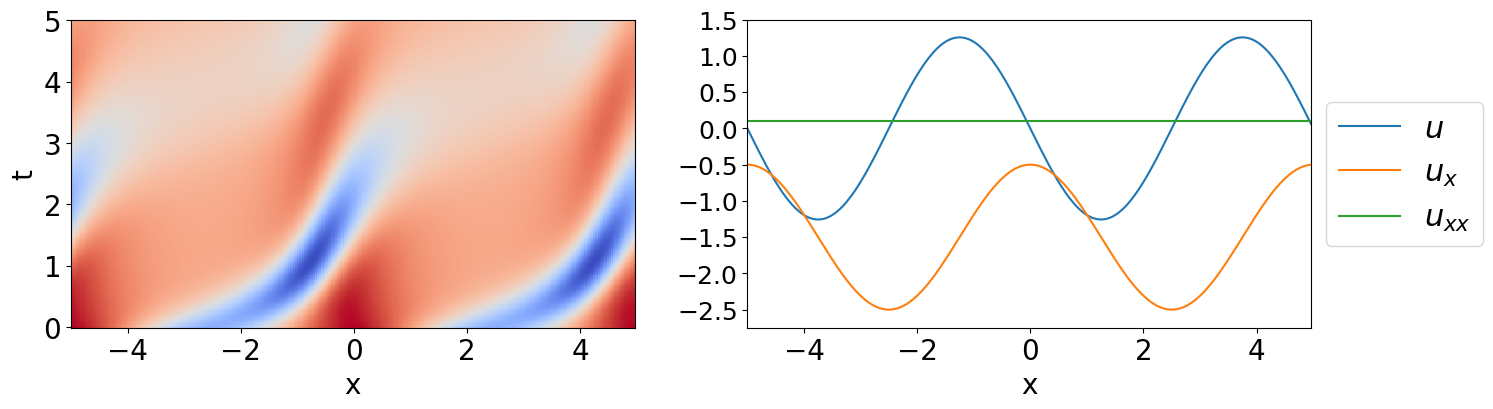

In [5]:
# Plot
u_x_true = -1.5 + 1.0*np.cos(2*x*np.pi/L) 
u_true = -2*np.pi/L*np.sin(2*x*np.pi/L)
u_xx_true = 0.1*np.ones(n)

fig = figure(figsize=(16,4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlim([x[0],x[-1]])

subplot(1,2,2)
plot(x,u_true, label='$u$')
plot(x,u_x_true, label='$u_{x}$')
plot(x,u_xx_true, label='$u_{xx}$')
xlim([x[0],x[-1]])
ylim([-2.75, 1.5])

xticks(fontsize = fontsize)
yticks(fontsize = fontsize-2)
xlabel('x', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
# fig.tight_layout()

In [6]:
Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'Fourier')
Theta = Theta[:, 1:]
rhs_des = np.array(rhs_des)[1:]

/Users/pongpisit/Desktop/research/parametric-discovery/parametric_pde_find.py:305: ComplexWarning: Casting complex values to real discards the imaginary part
  elif space_diff == 'Fourier': ux[:,i] = np.fft.ifft(ik**d*np.fft.fft(u[:,i]))


In [7]:
Theta_grouped = [real(Theta[n*np.arange(m)+j,:]) for j in range(n)]
Ut_grouped = [real(Ut[n*np.arange(m)+j]) for j in range(n)]

In [8]:
xi_true = np.zeros((len(rhs_des),m))
i_u_x = [i for i in range(len(rhs_des)) if rhs_des[i] == 'u_{x}'][0]
xi_true[i_u_x,:] = u_x_true

0 u
3 u_{x}
7 u_{xx}
MSE:  0.053207968889215355


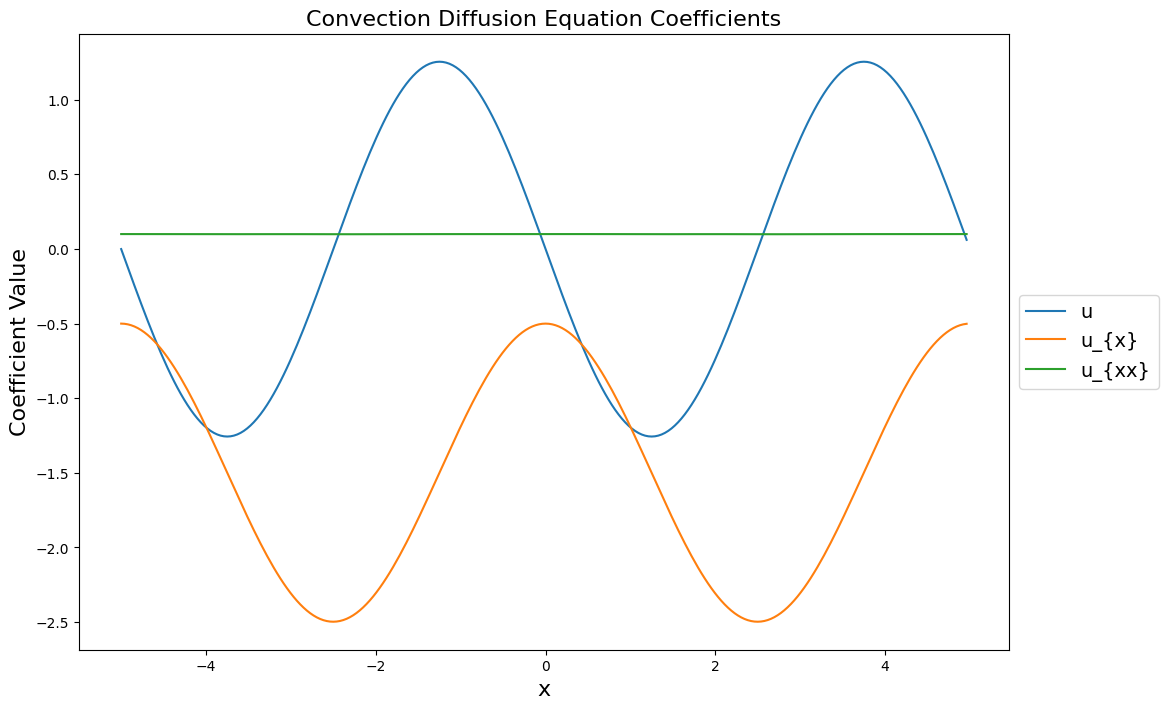

In [9]:
# Solve and plot
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi = Xi[np.argmin(Losses)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        print(j, rhs_des[j])
        plot(x, xi[j,:], label = rhs_des[j])
                
title('Convection Diffusion Equation Coefficients', fontsize = 16)
xlabel('x', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_clean_sgtr = Norm(xi-xi_true)**2/(m*len(rhs_des))
print('MSE: ', mse_clean_sgtr)

In [10]:
cg = pc(np.hstack([Ut, Theta]), alpha=0.01)
# cg = fci(np.hstack([Ut, Theta]), alpha=0.01)

Depth=5, working on node 15: 100%|███████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 548.06it/s]


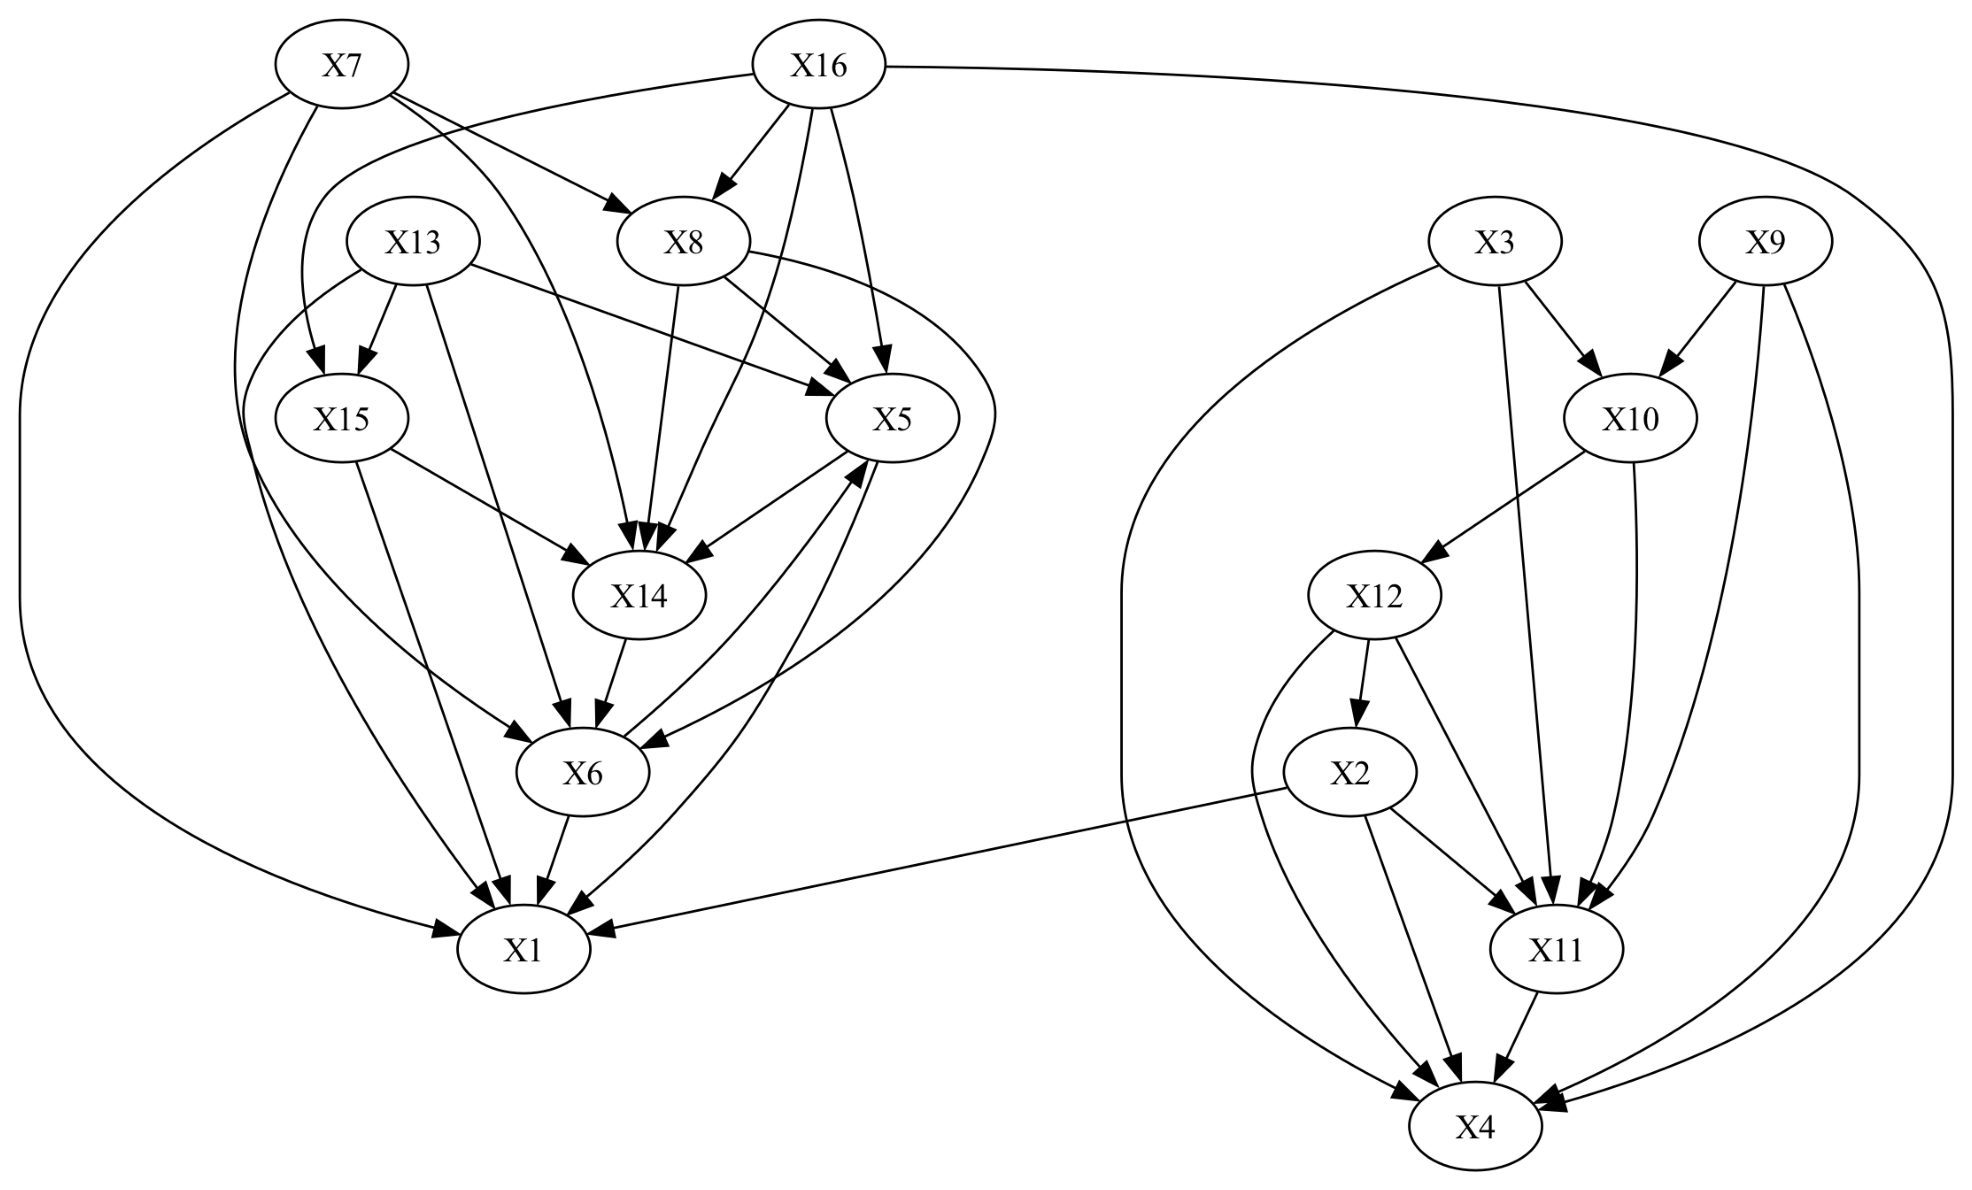

In [11]:
cg.draw_pydot_graph()

In [12]:
rhs_des[0], rhs_des[3], rhs_des[4], rhs_des[5], rhs_des[11], rhs_des[13]

('u', 'u_{x}', 'uu_{x}', 'u^2u_{x}', 'u_{xxx}', 'u^2u_{xxx}')

In [13]:
target_name = ['u_{t}']
target_name.extend(rhs_des)
df = pd.DataFrame(np.hstack([Ut, Theta]), columns=target_name)

In [14]:
model = CausalModel(df, treatment=['u', 'u_{x}', 'u_{xx}'], outcome='u_{t}')
# model.view_model()

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)       
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression")         
print(estimate)
print("Causal Estimate is " + str(estimate.value))

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                   
───────────────────(E[u_{t}])
d[u  u_{x}  u_{xx}]          
Estimand assumption 1, Unconfoundedness: If U→{u,u_{x},u_{xx}} and U→u_{t} then P(u_{t}|u,u_{x},u_{xx},,U) = P(u_{t}|u,u_{x},u_{xx},)

## Realized estimand
b: u_{t}~u+u_{x}+u_{xx}
Target units: ate

## Estimate
Mean value: -1.1874858390486545

Causal Estimate is -1.1874858390486545


/Users/pongpisit/anaconda3/envs/causal_inference/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [15]:
scores = []
for name in set([tuple(np.where(np.linalg.norm(xi, axis=1) > 0)[0]) for xi in Xi]):
    treatment = list(np.array(rhs_des)[list(name)])
    model = CausalModel(df, treatment=treatment, outcome='u_{t}')

    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)       
    estimate = model.estimate_effect(identified_estimand,
                                     method_name="backdoor.linear_regression")         
    
    scores.append((abs(estimate.value), treatment))

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}


/Users/pongpisit/anaconda3/envs/causal_inference/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}


/Users/pongpisit/anaconda3/envs/causal_inference/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}


/Users/pongpisit/anaconda3/envs/causal_inference/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}


/Users/pongpisit/anaconda3/envs/causal_inference/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}


/Users/pongpisit/anaconda3/envs/causal_inference/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/pongpisit/anaconda3/envs/causal_inference/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}


/Users/pongpisit/anaconda3/envs/causal_inference/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/pongpisit/anaconda3/envs/causal_inference/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/pongpisit/anaconda3/envs/causal_inference/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as position

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}


/Users/pongpisit/anaconda3/envs/causal_inference/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}


/Users/pongpisit/anaconda3/envs/causal_inference/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/pongpisit/anaconda3/envs/causal_inference/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [16]:
sorted(scores, reverse=True)[:5]

[(1.5976291850166329,
  ['u', 'u_{x}', 'u^2u_{x}', 'u_{xx}', 'uu_{xx}', 'u_{xxx}']),
 (1.3868272224630018,
  ['u',
   'u^3',
   'u_{x}',
   'u^2u_{x}',
   'u_{xx}',
   'uu_{xx}',
   'u^2u_{xx}',
   'u_{xxx}']),
 (1.2011743411586793,
  ['u',
   'u^3',
   'u_{x}',
   'u_{xx}',
   'uu_{xx}',
   'u^2u_{xx}',
   'u_{xxx}',
   'uu_{xxx}']),
 (1.1874858390486545, ['u', 'u_{x}', 'u_{xx}']),
 (1.0473164840755098, ['u', 'u_{x}'])]